In [2]:
# Автоматическая перезагрузка модулей при изменении
# Позволяет обновлять код в helper.py, plots.py, nlp.py без перезапуска ядра
%load_ext autoreload
%autoreload 2

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from functions import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sentence_transformers import SentenceTransformer
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import get_linear_schedule_with_warmup
from transformers import DataCollatorWithPadding, get_linear_schedule_with_warmup
from sklearn.dummy import DummyClassifier 
from sklearn.tree import DecisionTreeClassifier  # дерево решений
from sklearn.ensemble import RandomForestClassifier  # случайный лес
from lightgbm import LGBMClassifier  # градиентный бустинг
from helper import *
from plots import *
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from tensorflow.keras.layers import Input
from sklearn.svm import LinearSVC
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset





[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dima2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
df = pd.read_csv(r"c:\Users\dima2\Downloads\Telegram Desktop\train_science.csv")
print(df.head())

       Id                                            Comment      Topic
0   0x840  A few things. You might have negative- frequen...    Biology
1   0xbf0  Is it so hard to believe that there exist part...    Physics
2  0x1dfc                                     There are bees    Biology
3   0xc7e  I'm a medication technician. And that's alot o...    Biology
4   0xbba                     Cesium is such a pretty metal.  Chemistry


In [13]:
SEED=42

In [14]:
# Фильтруем строки, где количество слов >= 10
df = df[df['Comment'].str.split().str.len() >= 10]

# Сбрасываем индексы, чтобы было аккуратно
df = df.reset_index(drop=True)


In [15]:
#Разделим данные на треин валидацию и тест
X = df['Comment']
y = df['Topic']

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=SEED
)

print(len(X_train), len(X_val), len(X_test))

3804 815 816


In [16]:
#Закодируем названия топиков как числа чтобы работать с нейросетью
classes = sorted(pd.Series(y_train).unique())
label2id = {c:i for i, c in enumerate(classes)}
y_train_id = np.array([label2id[c] for c in y_train])
y_val_id   = np.array([label2id[c] for c in y_val])
y_test_id  = np.array([label2id[c] for c in y_test])


In [17]:

vectorizer = layers.TextVectorization(
    max_tokens=30000,
    output_mode="int",
    output_sequence_length=200,
    split="whitespace"
)
vectorizer.adapt(tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(128))


In [18]:
import tensorflow as tf
import keras
print("tf", tf.__version__)
print("keras", keras.__version__)


tf 2.20.0
keras 3.12.0


In [19]:
X_train_vec = vectorizer(np.array(X_train))

# Функция создания CNN-модели
def build_cnn_model(max_tokens, emb_dim, filters, kernel_sz, drop_rate, num_classes):
    inp = keras.Input(shape=(200,), dtype=tf.int64)  # теперь int64, а не string
    x = layers.Embedding(input_dim=max_tokens, output_dim=emb_dim)(inp)
    x = layers.Conv1D(filters, kernel_sz, padding="same", activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(drop_rate)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

cnn = build_cnn_model(
    max_tokens=30000,
    emb_dim=128,
    filters=256,
    kernel_sz=5,
    drop_rate=0.5,
    num_classes=3
)

cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 200, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,004,867 (15.28 MB)

 Trainable params: 4,004,867 (15.28 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
batch_size = 64
epochs = 10

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True
    )
]

X_train_vec = vectorizer(np.array(X_train))
X_val_vec   = vectorizer(np.array(X_val))

history = cnn.fit(
    x=X_train_vec,
    y=y_train_id,
    validation_data=(X_val_vec, y_val_id),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.4080 - loss: 1.0796 - val_accuracy: 0.4834 - val_loss: 1.0600
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6112 - loss: 0.9563 - val_accuracy: 0.6798 - val_loss: 0.8886
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8483 - loss: 0.5615 - val_accuracy: 0.7485 - val_loss: 0.6196
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9435 - loss: 0.2300 - val_accuracy: 0.7558 - val_loss: 0.6111
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9842 - loss: 0.0850 - val_accuracy: 0.7558 - val_loss: 0.6516
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9974 - loss: 0.0314 - val_accuracy: 0.7521 - val_loss: 0.6995


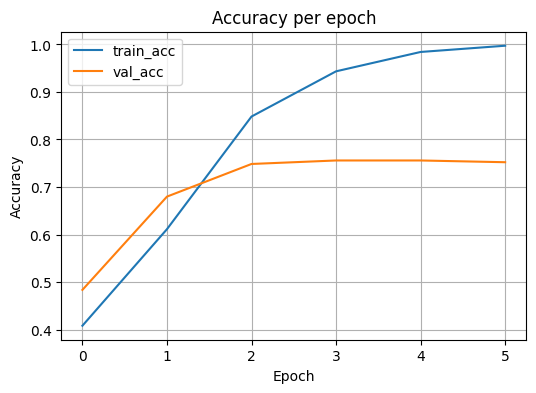

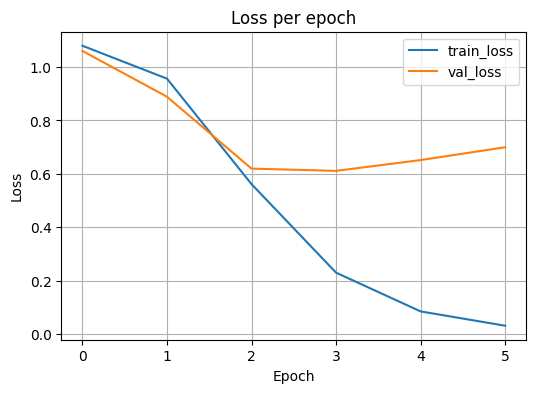

In [21]:


# История доступна в history.history: словарь списков по эпохам
# Обычно ключи: 'loss', 'accuracy', 'val_loss', 'val_accuracy'

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epoch')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
X_val_vec  = vectorizer(np.array(X_val, dtype=str))
X_test_vec = vectorizer(np.array(X_test, dtype=str))

y_val_pred = np.argmax(cnn.predict(X_val_vec, batch_size=128), axis=1)
print("VAL F1_macro:", f1_score(y_val_id, y_val_pred, average="macro"))
print("VAL report:\n", classification_report(y_val_id, y_val_pred))

# TEST
y_test_pred = np.argmax(cnn.predict(X_test_vec, batch_size=128), axis=1)
print("TEST F1_macro:", f1_score(y_test_id, y_test_pred, average="macro"))
print("TEST report:\n", classification_report(y_test_id, y_test_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
VAL F1_macro: 0.7490331141529403
VAL report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.80       329
           1       0.75      0.71      0.73       278
           2       0.69      0.73      0.71       208

    accuracy                           0.76       815
   macro avg       0.75      0.75      0.75       815
weighted avg       0.76      0.76      0.76       815

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
TEST F1_macro: 0.7760579940568858
TEST report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80       329
           1       0.76      0.73      0.74       278
           2       0.75      0.82      0.79       209

    accuracy                           0.78       816
   macro avg       0.77      0.78      0.78       816
weighted avg       0.78      0.78      0.78       816



In [23]:


EMB_MODEL_NAME = "all-MiniLM-L6-v2"  
st_model = SentenceTransformer(EMB_MODEL_NAME)


In [24]:


X_train_emb = st_model.encode(list(X_train), batch_size=64, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
X_val_emb   = st_model.encode(list(X_val),   batch_size=64, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
X_test_emb  = st_model.encode(list(X_test),  batch_size=64, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

X_train_emb.shape, X_val_emb.shape, X_test_emb.shape


Batches: 100%|██████████| 13/13 [00:05<00:00,  2.22it/s]


((3804, 384), (815, 384), (816, 384))

In [25]:
# Попробуем LinearSVC (часто лучше на эмбеддингах) и для сравнения LogReg
models = {
    "LinearSVC": (LinearSVC(), {"C":[0.5,1,2,4]}),
    "LogReg": (LogisticRegression(max_iter=2000, n_jobs=-1), {"C":[0.5,1,2,4]})
}

best_name, best_clf, best_val = None, None, -1
for name, (base_clf, grid) in models.items():
    gs = GridSearchCV(base_clf, grid, scoring="f1_macro", cv=5, n_jobs=-1, verbose=0)
    gs.fit(X_train_emb, y_train)
    val_f1 = f1_score(y_val, gs.predict(X_val_emb), average="macro")
    print(f"{name}  best_cv: {gs.best_score_:.4f}  val_f1: {val_f1:.4f}  best_params: {gs.best_params_}")
    if val_f1 > best_val:
        best_val = val_f1
        best_name = name
        best_clf = gs.best_estimator_

print(f"\nЛучший на VAL: {best_name}  F1_macro={best_val:.4f}")
print("\nVAL classification_report:\n", classification_report(y_val, best_clf.predict(X_val_emb)))

LinearSVC  best_cv: 0.7798  val_f1: 0.7591  best_params: {'C': 0.5}
LogReg  best_cv: 0.7860  val_f1: 0.7643  best_params: {'C': 0.5}

Лучший на VAL: LogReg  F1_macro=0.7643

VAL classification_report:
               precision    recall  f1-score   support

     Biology       0.77      0.83      0.80       329
   Chemistry       0.77      0.75      0.76       278
     Physics       0.77      0.71      0.74       208

    accuracy                           0.77       815
   macro avg       0.77      0.76      0.76       815
weighted avg       0.77      0.77      0.77       815



In [26]:
y_test_pred = best_clf.predict(X_test_emb)
print("TEST F1_macro:", f1_score(y_test, y_test_pred, average="macro"))
print("TEST report:\n", classification_report(y_test, y_test_pred))

TEST F1_macro: 0.8121044706688392
TEST report:
               precision    recall  f1-score   support

     Biology       0.81      0.83      0.82       329
   Chemistry       0.79      0.78      0.78       278
     Physics       0.84      0.82      0.83       209

    accuracy                           0.81       816
   macro avg       0.81      0.81      0.81       816
weighted avg       0.81      0.81      0.81       816



In [31]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# --- Выбираем модель и токенизатор ---
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# --- Создаём Hugging Face датасеты ---
ds_train = Dataset.from_dict({"text": list(X_train), "label": y_train_id})
ds_val   = Dataset.from_dict({"text": list(X_val),   "label": y_val_id})
ds_test  = Dataset.from_dict({"text": list(X_test),  "label": y_test_id})

raw_ds = DatasetDict(train=ds_train, validation=ds_val, test=ds_test)

# --- Токенизация с передачей токенизатора через fn_kwargs ---
tok_ds = raw_ds.map(
    tokenize_batch,
    batched=True,
    remove_columns=["text"],
    fn_kwargs={"tokenizer": tokenizer}  # сюда можно подставить любой другой токенизатор
)

# --- Переводим в PyTorch тензоры ---
tok_ds = tok_ds.with_format("torch")

# --- Проверим содержимое ---
print(tok_ds)


Map: 100%|██████████| 816/816 [00:00<00:00, 11116.80 examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 3804
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 815
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 816
    })
})


In [32]:
tok_ds["train"][0]

{'label': tensor(2),
 'input_ids': tensor([  101,  1045,  2293,  3666,  2310, 17728,  5332,  2819,  1012,  2023,
          2003,  1996,  2087,  2919, 12054,  2518,  1045,  1005,  2310,  2464,
          1012,  3084,  2033,  2215,  2000,  4553,  2062,  4283,  1012,  4942,
         11020,  3089, 10472,  2000,  2008,  7858,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   

In [33]:
classes = sorted(list(set(y_train)))   # список уникальных меток
label2id = {c: i for i, c in enumerate(classes)}
id2label = {i: c for c, i in label2id.items()}
num_labels = len(classes)


In [35]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:


#Проверяем имена колонок и в случае необходимости меняем
cols = set(tok_ds["train"].column_names)
if "label" in cols and "labels" not in cols:
    tok_ds = tok_ds.rename_column("label", "labels")

tok_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

#Объединяем текста в батчи
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

train_dl = DataLoader(tok_ds["train"], batch_size=16, shuffle=True,  collate_fn=data_collator)
val_dl   = DataLoader(tok_ds["validation"], batch_size=32, shuffle=False, collate_fn=data_collator)
test_dl  = DataLoader(tok_ds["test"], batch_size=32, shuffle=False, collate_fn=data_collator)


device = torch.device("cpu")  
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

num_epochs = 3
num_steps = num_epochs * len(train_dl)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_steps)#линейнро уменьшаем learning rate

best_val_f1, best_state = -1.0, None
torch.manual_seed(SEED)
np.random.seed(SEED)

#Обучение
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0

    for batch in train_dl:
        batch = {k: v.to(device) for k, v in batch.items()}#переносим весь батч на CPU
        optimizer.zero_grad()#обнуляем старые градиенты
        out = model(**batch) #считает loss сам, т.к. есть labels
        loss = out.loss#средний по батчу loss
        loss.backward()#обратное распространение ошибки, считает градиенты по всем trainable-параметрам.
        optimizer.step()#обновляет веса на основе градиентов
        scheduler.step()#каждый шаг немного уменьшает learning rate
        total_loss += loss.item()#копим суммарный трен-лосс за эпоху (для лога)

    avg_train_loss = total_loss / max(1, len(train_dl))

    #Валидация
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for batch in val_dl:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch.pop("labels")
            logits = model(**batch).logits
            pred = torch.argmax(logits, dim=1)
            ys.extend(labels.cpu().numpy().tolist())
            preds.extend(pred.cpu().numpy().tolist())

    val_f1 = f1_score(ys, preds, average="macro")
    print(f"Epoch {epoch} | train_loss={avg_train_loss:.4f} | val_f1={val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

#ТЕСТ
if best_state is not None:
    model.load_state_dict(best_state)

model.eval()
ys, preds = [], []
with torch.no_grad():
    for batch in test_dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch.pop("labels")
        logits = model(**batch).logits
        pred = torch.argmax(logits, dim=1)
        ys.extend(labels.cpu().numpy().tolist())
        preds.extend(pred.cpu().numpy().tolist())
#Вывод результатов
print("TEST F1_macro:", f1_score(ys, preds, average="macro"))
print("TEST report:\n", classification_report(ys, preds, target_names=[id2label[i] for i in range(num_labels)]))


Epoch 1 | train_loss=0.6666 | val_f1=0.7851
Epoch 2 | train_loss=0.3865 | val_f1=0.7943
Epoch 3 | train_loss=0.2694 | val_f1=0.7971
TEST F1_macro: 0.8062831350675044
TEST report:
               precision    recall  f1-score   support

     Biology       0.83      0.84      0.83       329
   Chemistry       0.79      0.79      0.79       278
     Physics       0.80      0.79      0.80       209

    accuracy                           0.81       816
   macro avg       0.81      0.81      0.81       816
weighted avg       0.81      0.81      0.81       816



In [ ]:
# =========================================
# 1. Преобразуем эмбеддинги и метки в тензоры PyTorch
# =========================================
X_train_tensor = torch.tensor(X_train_emb, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_emb, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_emb, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_id, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val_id, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test_id, dtype=torch.long)

# =========================================
# 2. Создаем TensorDataset и DataLoader для батчей
# =========================================
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dl  = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# =========================================
# 3. Определяем BiLSTM с Attention
# =========================================
class BiLSTMAttention(nn.Module):
    def __init__(self, emb_dim, hidden_dim, num_classes, dropout=0.5):
        super(BiLSTMAttention, self).__init__()
        self.lstm = nn.LSTM(input_size=emb_dim,
                            hidden_size=hidden_dim,
                            batch_first=True,
                            bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        # x shape: [batch_size, seq_len, emb_dim] (для одного embedding seq_len=1)
        lstm_out, _ = self.lstm(x)  # [batch, seq_len, hidden*2]
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # [batch, seq_len, 1]
        context = torch.sum(attn_weights * lstm_out, dim=1)  # [batch, hidden*2]
        context = self.dropout(context)
        out = self.fc(context)
        return out


In [ ]:
# =========================================
# 4. Настройка устройства и модели
# =========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMAttention(emb_dim=X_train_emb.shape[1], hidden_dim=128, num_classes=num_labels)
model.to(device)

criterion = nn.CrossEntropyLoss()         # loss для multi-class классификации
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)  # оптимизатор Adam

num_epochs = 20
best_val_f1, best_state = -1.0, None  # для сохранения лучших весов

# =========================================
# 5. Цикл обучения
# =========================================
for epoch in range(1, num_epochs + 1):
    model.train()  # переводим модель в режим обучения
    total_loss = 0
    for X_batch, y_batch in train_dl:
        # переносим данные на GPU, если доступен
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()                   # обнуляем старые градиенты
        outputs = model(X_batch.unsqueeze(1))   # добавляем размер seq_len=1, чтобы LSTM ожидала [batch, seq_len, emb_dim]
        loss = criterion(outputs, y_batch)      # вычисляем loss
        loss.backward()                         # обратное распространение ошибки
        optimizer.step()                        # обновляем веса
        total_loss += loss.item()               # накапливаем loss для среднего
    avg_loss = total_loss / len(train_dl)

    # Валидация
    model.eval()  # режим оценки (отключаем dropout)
    ys, preds = [], []
    with torch.no_grad():  # не считаем градиенты
        for X_batch, y_batch in val_dl:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch.unsqueeze(1))
            pred = torch.argmax(outputs, dim=1)  # получаем предсказанные классы
            ys.extend(y_batch.cpu().numpy())
            preds.extend(pred.cpu().numpy())
    val_f1 = f1_score(ys, preds, average="macro")
    print(f"Epoch {epoch} | Train Loss={avg_loss:.4f} | Val F1={val_f1:.4f}")

    # Сохраняем лучшие веса
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = model.state_dict()

Epoch 1 | Train Loss=0.7177 | Val F1=0.7572
Epoch 2 | Train Loss=0.4870 | Val F1=0.7740
Epoch 3 | Train Loss=0.4634 | Val F1=0.7611
Epoch 4 | Train Loss=0.4488 | Val F1=0.7595
Epoch 5 | Train Loss=0.4330 | Val F1=0.7585
Epoch 6 | Train Loss=0.4198 | Val F1=0.7601
Epoch 7 | Train Loss=0.4098 | Val F1=0.7543
Epoch 8 | Train Loss=0.3994 | Val F1=0.7575
Epoch 9 | Train Loss=0.3916 | Val F1=0.7684
Epoch 10 | Train Loss=0.3768 | Val F1=0.7591
Epoch 11 | Train Loss=0.3656 | Val F1=0.7656
Epoch 12 | Train Loss=0.3528 | Val F1=0.7627
Epoch 13 | Train Loss=0.3381 | Val F1=0.7624
Epoch 14 | Train Loss=0.3207 | Val F1=0.7650
Epoch 15 | Train Loss=0.3116 | Val F1=0.7603
Epoch 16 | Train Loss=0.2945 | Val F1=0.7638
Epoch 17 | Train Loss=0.2749 | Val F1=0.7616
Epoch 18 | Train Loss=0.2507 | Val F1=0.7733
Epoch 19 | Train Loss=0.2327 | Val F1=0.7767
Epoch 20 | Train Loss=0.2241 | Val F1=0.7771


In [ ]:
# =========================================
# 6. Тестирование на лучшей модели
# =========================================
if best_state is not None:
    model.load_state_dict(best_state)

model.eval()
ys, preds = [], []
with torch.no_grad():
    for X_batch, y_batch in test_dl:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch.unsqueeze(1))
        pred = torch.argmax(outputs, dim=1)
        ys.extend(y_batch.cpu().numpy())
        preds.extend(pred.cpu().numpy())

print("TEST F1_macro:", f1_score(ys, preds, average="macro"))
print("TEST report:\n", classification_report(ys, preds, target_names=[id2label[i] for i in range(num_labels)]))


TEST F1_macro: 0.799347374023423
TEST report:
               precision    recall  f1-score   support

     Biology       0.82      0.82      0.82       329
   Chemistry       0.79      0.75      0.77       278
     Physics       0.79      0.83      0.81       209

    accuracy                           0.80       816
   macro avg       0.80      0.80      0.80       816
weighted avg       0.80      0.80      0.80       816

